### IMPORTING PACKAGES

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Data

In [2]:
df_train=pd.read_csv('train.csv')
print(df_train.shape)
df_train.head()

(1157, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
2,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
3,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
4,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


## EDA

1    586
0    571
Name: CLASS, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


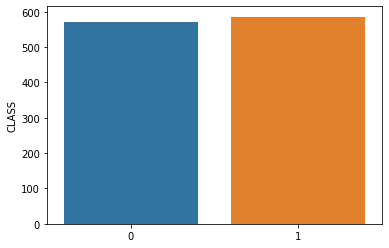

In [3]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['CLASS'].value_counts()
print(x)
sns.barplot(x.index,x)

In [4]:
#Missing values
df_train.isna().sum()

COMMENT_ID      0
AUTHOR          0
DATE          138
CONTENT         0
CLASS           0
dtype: int64

In [5]:
#1. WORD-COUNT
df_train['word_count'] = df_train['CONTENT'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['CLASS']==1]['word_count'].mean()) #Ads Comments
print(df_train[df_train['CLASS']==0]['word_count'].mean()) #Non-Ads Comments
#Ads Comments are more wordy than the non-Ads Comments

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['CONTENT'].apply(lambda x: len(str(x)))
print(df_train[df_train['CLASS']==1]['char_count'].mean()) #Ads Comments
print(df_train[df_train['CLASS']==0]['char_count'].mean()) #Non-Ads Comments
#Ads Comments are longer than the non-Ads Comments

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['CONTENT'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['CLASS']==1]['unique_word_count'].mean()) #Ads Comments
print(df_train[df_train['CLASS']==0]['unique_word_count'].mean()) #Non-Ads Comments

22.12627986348123
8.84938704028021
138.26621160409556
49.08406304728546
18.32764505119454
8.302977232924693


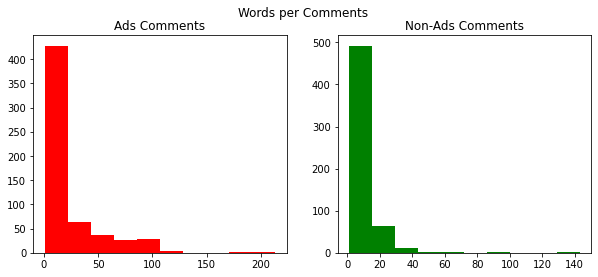

In [6]:
#Plotting word-count per Comments
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['CLASS']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Ads Comments')
train_words=df_train[df_train['CLASS']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-Ads Comments')
fig.suptitle('Words per Comments')
plt.show()

## PRE-PROCESSING

In [7]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [8]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


In [9]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['CONTENT'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,clean_text
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,huh anyway check tube channel kobyoshi
1,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,shake sexy as channel enjoy
2,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch v vtarggvgtwq check
3,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1,subscribe channel
4,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1,u check channel tell next


### Word2Vec model

In [10]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [11]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["CLASS"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

### Building ML models (Text-classification)

#### LR (tf-idf)

In [12]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC_SCORE:', roc_auc)  

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       113
           1       0.94      0.92      0.93       119

    accuracy                           0.93       232
   macro avg       0.93      0.93      0.93       232
weighted avg       0.93      0.93      0.93       232

Confusion Matrix: [[106   7]
 [ 10 109]]
ROC_AUC_SCORE: 0.9831932773109243


#### NB (tf-idf)

In [13]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC_SCORE:', roc_auc)  




              precision    recall  f1-score   support

           0       0.93      0.78      0.85       113
           1       0.82      0.94      0.87       119

    accuracy                           0.86       232
   macro avg       0.87      0.86      0.86       232
weighted avg       0.87      0.86      0.86       232

Confusion Matrix: [[ 88  25]
 [  7 112]]
ROC_AUC_SCORE: 0.9667583847698372


#### LR (w2v)

In [14]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC_SCORE:', roc_auc)  

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       113
           1       0.64      0.68      0.66       119

    accuracy                           0.64       232
   macro avg       0.64      0.64      0.64       232
weighted avg       0.64      0.64      0.64       232

Confusion Matrix: [[68 45]
 [38 81]]
ROC_AUC_SCORE: 0.6851342306834237


### TESTING THE MODEL ON UNLABELLED DATASET

In [15]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('test.csv')  #reading the data
df_test['clean_text'] = df_test['CONTENT'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['CLASS']= y_predict
print(df_test.head())
final=df_test[['COMMENT_ID','CONTENT','CLASS']].reset_index(drop=True)
final.to_csv('submission.csv')

   ID                                   COMMENT_ID            AUTHOR  \
0   0  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
1   1  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
2   2  LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc      Jason Haddad   
3   3        z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k      Bob Kanowski   
4   4          z13ttt1jcraqexk2o234ghbgzxymz1zzi04              Cony   

                  DATE                                            CONTENT  \
0  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
1  2013-11-08T17:34:21             just for test I have to say murdev.com   
2  2013-11-26T02:55:11  Hey, check out my new website!! This site is a...   
3  2013-11-28T12:33:27  i turned it on mute as soon is i came on i jus...   
4  2013-11-28T16:01:47    You should check my channel for Funny VIDEOS!!﻿   

                                          clean_text  predict_prob  CLASS  
0  hey guy check new channel